# Camera Calibration

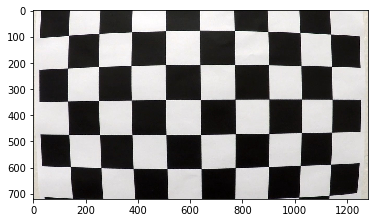

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read in a calibration image
img = mpimg.imread('./camera_cal/calibration1.jpg')
h, w = img.shape[:2]
plt.imshow(img)

In [8]:
import glob
%matplotlib inline

# Read in and make a list of images
images = glob.glob('./camera_cal/calibration*.jpg')

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# prepare object points, like (0,0,0)....
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

# if corners are found, add object points, image points
fnames_valid = []
for fname in images:
    img = mpimg.imread(fname)
    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        fnames_valid.append(fname)
        # draw and display the corners
        # print("got!")
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         plt.figure()
#         plt.imshow(img)
    else:
        print("lost!")

lost!
lost!
lost!


## Distrotion-corrested image demonstration

In [9]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

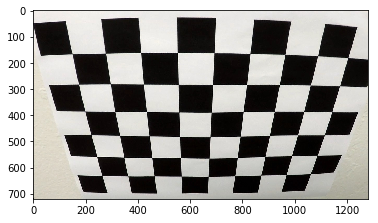

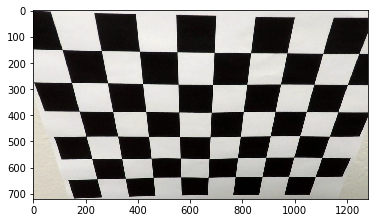

In [10]:
import pickle

img = mpimg.imread('./camera_cal/calibration2.jpg')
# undist
undist, mtx, dist = cal_undistort(img, objpoints, imgpoints)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(undist)

data = {
    'mtx': mtx,
    'dist': dist
}

with open('camera.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

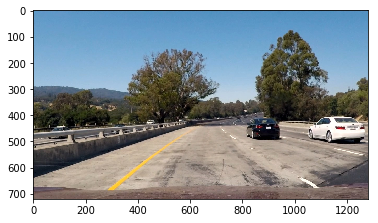

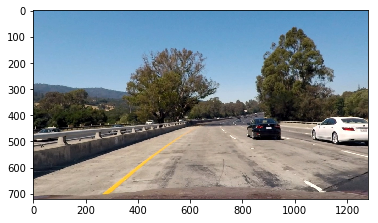

In [11]:
test = mpimg.imread('./test_images/test1.jpg')
# undist
undist = cv2.undistort(test, mtx, dist, None, mtx)
plt.figure()
plt.imshow(test)
plt.figure()
plt.imshow(undist)

## Test images

In [62]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    scale_sobel = np.uint8(255*sobel/np.max(sobel))
    binary_output = np.zeros_like(scale_sobel)
    binary_output[(scale_sobel >= mag_thresh[0]) & (scale_sobel <= mag_thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direct = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direct)
    binary_output[(direct >= thresh[0]) & (direct <= thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobelorient = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobelorient = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobelorient)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    binary_output = np.zeros_like(hsv[:,:,1])
    binary_output[mask == 255] = 1

    return binary_output

def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    binary_output = np.zeros_like(image[:,:,1])
    binary_output[mask == 255] = 1

    return binary_output

def hls_grad(img):
    sxbinary = abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=100)
    sybinary = abs_sobel_thresh(img, orient='y', thresh_min=50, thresh_max=100)
#     dirbinary = dir_threshold(img, sobel_kernel=15, thresh=(0.7,1.3))
#     magbinary = mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255))
    #s_binary = hls_select(img, thresh=(140,255))
    y_binary = select_yellow(img)
    w_binary = select_white(img)
    # color binary
    color_binary = np.dstack(( np.zeros_like(sxbinary), y_binary, w_binary)) * 255
    # combined image
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(w_binary == 1) | (y_binary == 1) | (sxbinary == 1) & (sybinary == 1)] = 1
    return color_binary, combined_binary

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,)
    else:
        ignore_mask_color = 255
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def transform():
    src = np.float32(
        [[247, 700],
         [590, 450],
         [700, 450],
         [1080, 700]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def find_lane(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
#         # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
#         (0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
#         (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    return left_fit, right_fit, left_fit_cr, right_fit_cr, y_eval

#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

### read and undistort test images

In [48]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera.pickle", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in and make a list of images
test_images = glob.glob('./test_images/*.jpg')

#undistort
undist_imgs = []
for image in test_images:
    img = mpimg.imread(image)
    undist_imgs.append(cv2.undistort(img, mtx, dist, None, mtx))

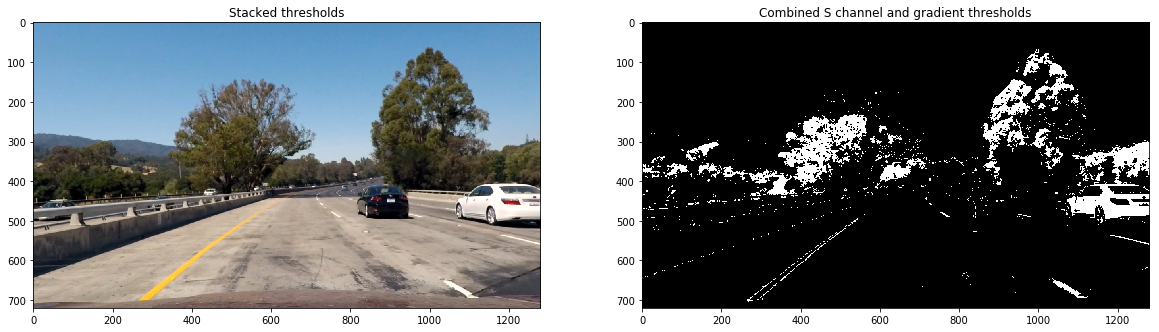

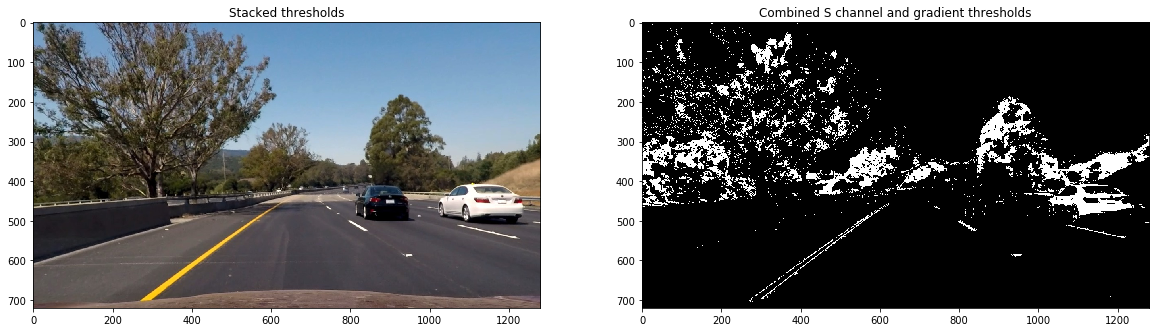

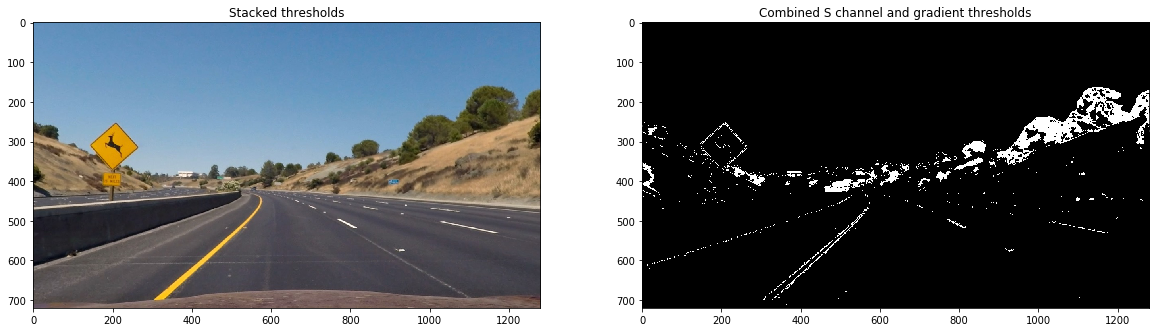

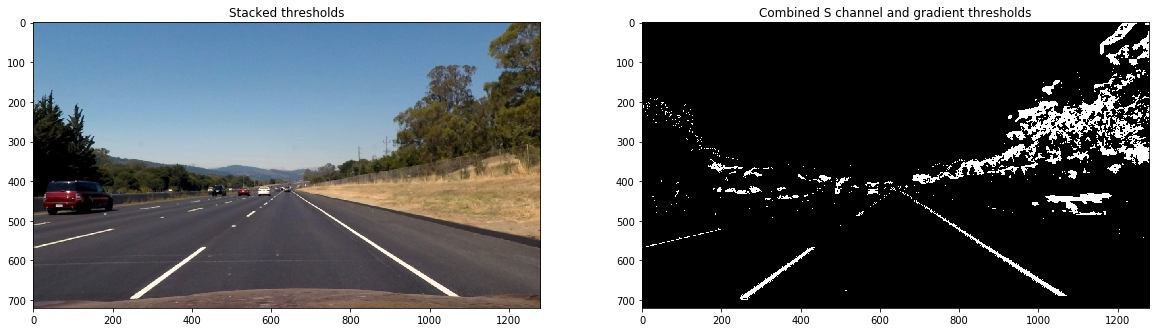

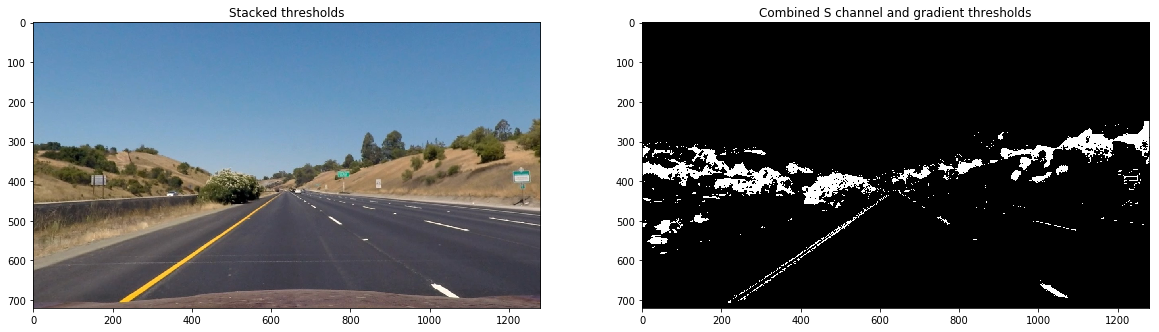

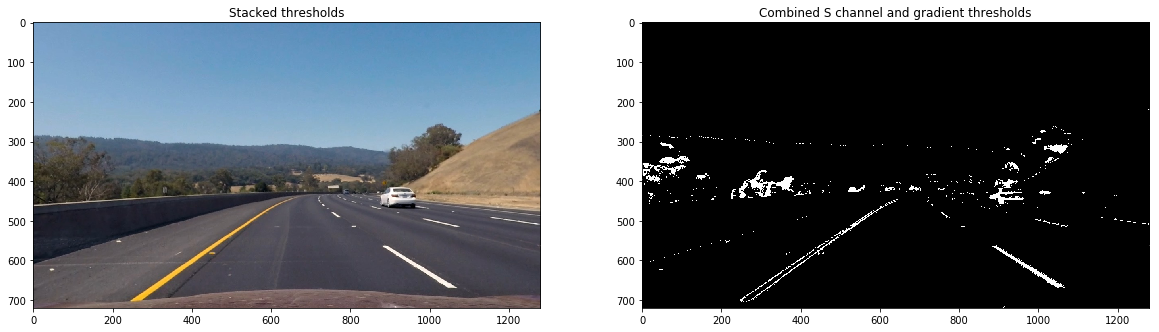

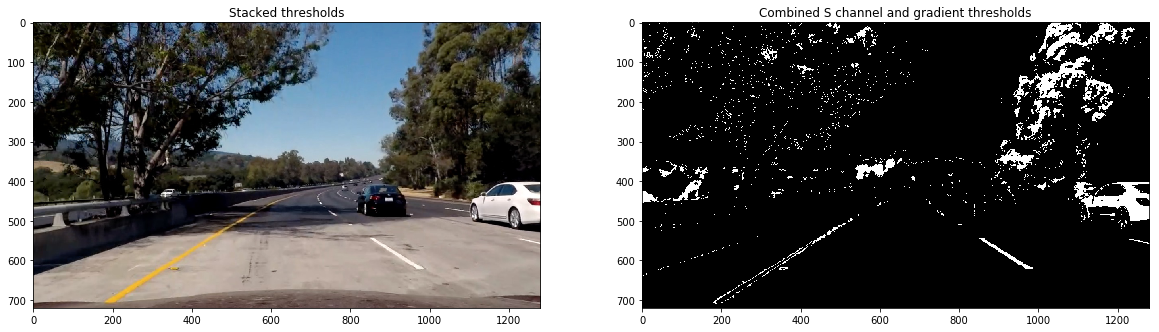

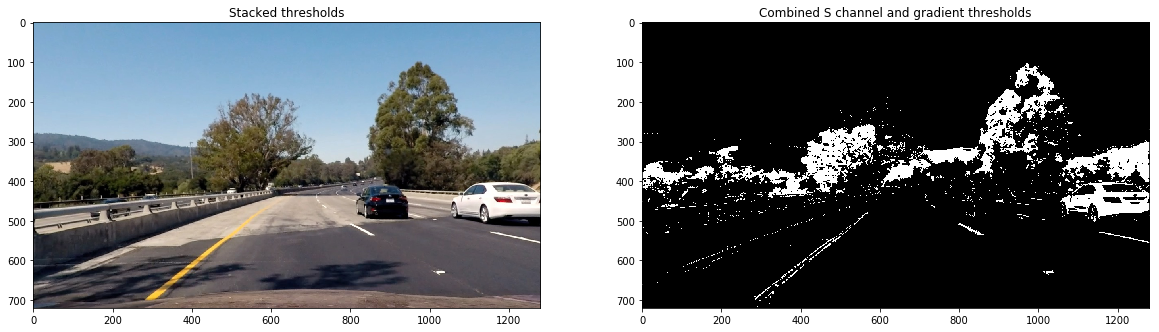

In [50]:
%matplotlib inline
for undist_img in undist_imgs:
#     sxbinary = abs_sobel_thresh(undist_img, orient='x', thresh_min=30, thresh_max=100)
#     sybinary = abs_sobel_thresh(undist_img, orient='y', thresh_min=50, thresh_max=100)
# #     dirbinary = dir_threshold(img, sobel_kernel=15, thresh=(0.7,1.3))
# #     magbinary = mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255))
#     s_binary = hls_select(undist_img, thresh=(140,255))
#     # color binary
#     color_binary = np.dstack(( np.zeros_like(sxbinary), s_binary, sxbinary)) * 255
#     # combined image
#     combined_binary = np.zeros_like(sxbinary)
#     combined_binary[(s_binary == 1) | (sxbinary == 1) | (sybinary == 1)] = 1
    color_binary, combined_binary = hls_grad(undist_img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(undist_img)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')


### perspective transform

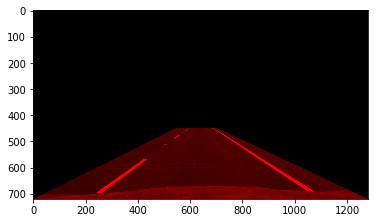

In [15]:
%matplotlib inline

# test straight lines and find points
raw = mpimg.imread('./test_images/straight_lines2.jpg')
imshape = raw.shape
undist_raw = cv2.undistort(raw, mtx, dist, None, mtx)
color_binary, combined_binary = hls_grad(undist_raw)
vertices = np.array([[(0,imshape[0]),(550, 448), (700, 448), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(undist_raw, vertices)

plt.imshow(masked_image)
# test curved lines

In [16]:
src = np.float32(
    [[247, 700],
     [590, 450],
     [700, 450],
     [1080, 700]])

dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

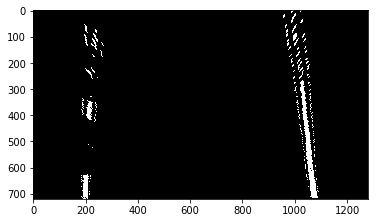

In [17]:
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

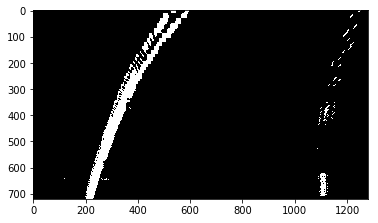

In [18]:
# test curved lines and find points
rawcurve = mpimg.imread('./test_images/test3.jpg')
imshape = rawcurve.shape
undist_raw = cv2.undistort(rawcurve, mtx, dist, None, mtx)
color_binary, combined_binary = hls_grad(undist_raw)
vertices = np.array([[(0,imshape[0]),(550, 448), (700, 448), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(undist_raw, vertices)
binary_warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap="gray")

(720, 0)

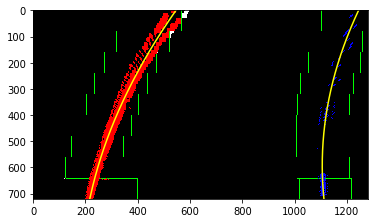

In [19]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

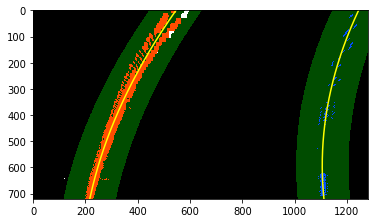

In [20]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


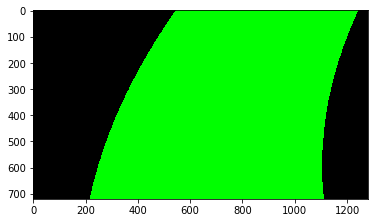

In [21]:
blank_mask = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_mask.astype(np.uint8), cv2.COLOR_GRAY2RGB)
trace = colour_canvas

for index, lrx in enumerate(zip(left_fitx, right_fitx)):
    blank_mask[index][int(lrx[0]):int(lrx[1])] = 1

trace[blank_mask == 1] = [0,255,0]
plt.imshow(trace)

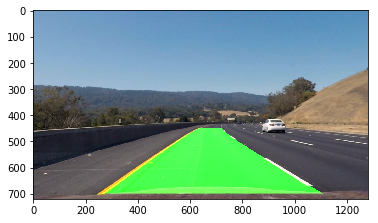

In [22]:
# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

# Convert to colour
combined_img = cv2.add(lane_lines, undist_raw)
plt.imshow(combined_img)

In [33]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
print(left_curverad, right_curverad)
curvature = (left_curverad + right_curverad) / 2
center_y = 719
center_left = left_fit[0]*center_y**2 + left_fit[1]*center_y + left_fit[2]
center_right = right_fit[0]*center_y**2 + right_fit[1]*center_y + right_fit[2]
center = (1.5 * center_right - center_left) / 2
print("the pos of vehicle is: ",center)

484.618835148 416.497007255
the pos of vehicle is:  725.290765808


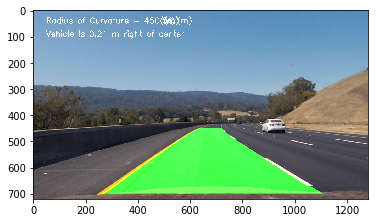

In [58]:
vehicle_pos = center / 12800 * 3.7
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(combined_img, 'Radius of Curvature = %.2f (m)' % curvature, (50, 50), font, 1, (255,255,255), 2)
direction = "left" if vehicle_pos < 0 else "right"
cv2.putText(combined_img, 'Vehicle is %.2f m %s of center' % (np.abs(vehicle_pos), direction), (50, 100), font, 1, (255,255,255), 2)

plt.imshow(combined_img)

## Image pipeline

In [63]:
def image_pipeline(file, filepath=False):
    global prev_left_coeffs
    global prev_right_coeffs
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = mpimg.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape
    
    M, Minv = transform()

    height = raw.shape[0]
    offset = 50
    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = offset_height / steps
    window_radius = 200
    medianfilt_kernel_size = 51

    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Combine color and gradience
    _ , combined_binary = hls_grad(image)
    binary_warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    
    left_fit, right_fit, left_fit_cr, right_fit_cr, y_eval = find_lane(binary_warped)
    blank_mask = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_mask.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    trace = colour_canvas
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    for index, lrx in enumerate(zip(left_fitx, right_fitx)):
        blank_mask[index][int(lrx[0]):int(lrx[1])] = 1

    trace[blank_mask == 1] = [0,255,0]
    # Warp lane boundaries back onto original image
    lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

    # Convert to colour
    combined_img = cv2.add(lane_lines, image)
    
#     # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
#     # Fit new polynomials to x,y in world space
#     left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
#     right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
#     # Define y-value where we want radius of curvature
#     # I'll choose the maximum y-value, corresponding to the bottom of the image
#     y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = (left_curverad + right_curverad) / 2
    center_y = 719
    center_left = left_fit[0]*center_y**2 + left_fit[1]*center_y + left_fit[2]
    center_right = right_fit[0]*center_y**2 + right_fit[1]*center_y + right_fit[2]
    center = (1.5 * center_right - center_left) / 2
    vehicle_pos = center / 12800 * 3.7
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(combined_img, 'Radius of Curvature = %.2f (m)' % curvature, (50, 50), font, 1, (255,255,255), 2)
    direction = "left" if vehicle_pos < 0 else "right"
    cv2.putText(combined_img, 'Vehicle is %.2f m %s of center' % (np.abs(vehicle_pos), direction), (50, 100), font, 1, (255,255,255), 2)
    #     plt.imshow(combined_img)

    return combined_img

In [55]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

with open("camera.pickle", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

# Read in and make a list of images
test_images = glob.glob('./test_images/*.jpg')

for image in test_images:
    plt.figure()
    combined_image = image_pipeline(image, filepath=True)
    
    


484.618835148 416.497007255
484.618835148 416.497007255
484.618835148 416.497007255
484.618835148 416.497007255
484.618835148 416.497007255
484.618835148 416.497007255
484.618835148 416.497007255
484.618835148 416.497007255


## Video pipeline

In [52]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [64]:
output = 'project_output_colour.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


100%|█████████▉| 1260/1261 [02:43<00:00,  7.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

CPU times: user 4min, sys: 2.23 s, total: 4min 2s
Wall time: 2min 44s
